In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import optuna
import joblib
import shap

# STATISTICS
from statsmodels.graphics.gofplots import qqplot

# HYPOTHESIS TESTING
from scipy.stats import ks_2samp

# Sklearn preprocessing
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import AdaBoostRegressor,StackingRegressor,RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, SelectFromModel, RFECV
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_approximation import Nystroem

#notebook settings
sns.set_theme(style = 'white', palette = 'colorblind')
pal = sns.color_palette('colorblind')

pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

SEED = 42

In [44]:
# Load data
train = pd.read_csv('data/train.csv',index_col=0)
test = pd.read_csv('data/test.csv',index_col=0)
sub = pd.read_csv('data/sample_submission.csv',index_col=0)

# Understanding Abalone Dataset Features

- Sex: This feature represents the gender of the abalone,categorized as male (M), female (F), or infant (I).

- Length: The length feature denotes the longest measurement of the abalone shell, from the apex to the base, measured in millimeters.

- Diameter: Diameter represents the measurement of the abalone shell perpendicular to its length, also measured in millimeters.

- Height: This feature signifies the height of the abalone shell, measured perpendicular to the plane formed by the length and diameter, in millimeters.

- Whole weight: Whole weight indicates the total weight of the abalone, encompassing both the meat and the shell, measured in grams.

- Whole weight.1 (Shucked weight): This feature represents the weight of the abalone meat only, measured in grams. It indicates the amount of meat extracted from the shell.

- Whole weight.2 (Viscera weight): Viscera weight signifies the weight of the abalone gut after bleeding, measured in grams.It provides insights into the weight of the internal organs of the abalone.

- Shell weight: This feature represents the weight of the abalone shell only, excluding the meat, measured in grams. It provides insights into the weight distribution between the shell and the edible portion of the abalone.

- Rings: Rings signify the number of rings present on the abalone shell, serving as an indicator of the abalone's age.

In [45]:
train.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
id,,,,,,,,,
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [46]:
test.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
id,,,,,,,,
90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


In [47]:
def rename_and_lowercase(df):
    df = df.rename(columns = {'Whole weight.1':'shucked weight'})
    df = df.rename(columns = {'Whole weight.2':'viscera weight'})
    df = df.rename(columns=lambda x: x.lower().replace(' ', '_'))
    return df

train = rename_and_lowercase(train)
test = rename_and_lowercase(test)

train.columns, test.columns

(Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight', 'rings'],
       dtype='object'),
 Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight'],
       dtype='object'))

# Feature Engineering

In [48]:
# link about age of abalones
#https://ubc-mds.github.io/abalone_age_classification/README.html

## Age Group:
# Add a classification target columns. If rings > 11, then classified as old
#train["Is old"] = np.where(train["rings"] > 11, "old", "young")

# later might try create a classification model to predict if the abalone is old or young, apply to train and test data
# afterwards use the predicted column as a feature in the regression model for predict rings of the abalone

In [49]:
def apply_transformations(train, test):
    
    train = train.copy()
    test = test.copy()
    
    # Dimension Ratios:
    train['length_diameter_ratio'] = train['length'] / train['diameter']
    train['height_diameter_ratio'] = train['height'] / train['diameter']
    test['length_diameter_ratio'] = test['length'] / test['diameter']
    test['height_diameter_ratio'] = test['height'] / test['diameter']

    ## Volume:
    train['volume'] = (4/3) * np.pi * (train['length']/2) * (train['diameter']/2) * (train['height']/2)
    test['volume'] = (4/3) * np.pi * (test['length']/2) * (test['diameter']/2) * (test['height']/2)

    ## Shell Thickness:
    train['shell_thickness_to_length'] = (train['whole_weight'] - train['shucked_weight']) / train['length']
    train['shell_thickness_to_diameter'] = (train['whole_weight'] - train['shucked_weight']) / train['diameter']
    test['shell_thickness_to_length'] = (test['whole_weight'] - test['shucked_weight']) / test['length']
    test['shell_thickness_to_diameter'] = (test['whole_weight'] - test['shucked_weight']) / test['diameter']

    ## Interaction Terms:
    train['length_diameter_interact'] = train['length'] * train['diameter']
    train['whole_shell_weight_interact'] = train['whole_weight'] * train['shell_weight']
    test['length_diameter_interact'] = test['length'] * test['diameter']
    test['whole_shell_weight_interact'] = test['whole_weight'] * test['shell_weight']

    ## Polynomial Features:
    train['length_squared'] = train['length'] ** 2
    train['diameter_cubed'] = train['diameter'] ** 3
    test['length_squared'] = test['length'] ** 2
    test['diameter_cubed'] = test['diameter'] ** 3
    
    # Drop columns
    #train = train.drop(columns = ['length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight'])
    #test = test.drop(columns = ['length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight'])

    return train, test

In [50]:
train, test = apply_transformations(train, test)

train.columns, test.columns

(Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight', 'rings', 'length_diameter_ratio',
        'height_diameter_ratio', 'volume', 'shell_thickness_to_length',
        'shell_thickness_to_diameter', 'length_diameter_interact',
        'whole_shell_weight_interact', 'length_squared', 'diameter_cubed'],
       dtype='object'),
 Index(['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight',
        'viscera_weight', 'shell_weight', 'length_diameter_ratio',
        'height_diameter_ratio', 'volume', 'shell_thickness_to_length',
        'shell_thickness_to_diameter', 'length_diameter_interact',
        'whole_shell_weight_interact', 'length_squared', 'diameter_cubed'],
       dtype='object'))

In [51]:
def generate_summary_statistics(data):
    summary_table = pd.DataFrame(data.dtypes, columns=['dtypes'])
    summary_table['Missing'] = data.isnull().sum()
    summary_table['Unique'] = data.nunique()
    summary_table['Count'] = data.count()
    summary_table['Duplicated'] = data.duplicated().sum()
    return summary_table

In [52]:
# summary statistics of train data
generate_summary_statistics(train)

,dtypes,Missing,Unique,Count,Duplicated
sex,object,0,3,90615,0
length,float64,0,157,90615,0
diameter,float64,0,126,90615,0
height,float64,0,90,90615,0
whole_weight,float64,0,3175,90615,0
shucked_weight,float64,0,1799,90615,0
viscera_weight,float64,0,979,90615,0
shell_weight,float64,0,1129,90615,0
rings,int64,0,28,90615,0
length_diameter_ratio,float64,0,1742,90615,0


In [53]:
generate_summary_statistics(test)

,dtypes,Missing,Unique,Count,Duplicated
sex,object,0,3,60411,0
length,float64,0,148,60411,0
diameter,float64,0,130,60411,0
height,float64,0,85,60411,0
whole_weight,float64,0,3037,60411,0
shucked_weight,float64,0,1747,60411,0
viscera_weight,float64,0,960,60411,0
shell_weight,float64,0,1089,60411,0
length_diameter_ratio,float64,0,1585,60411,0
height_diameter_ratio,float64,0,1232,60411,0


In [54]:
# check the distribution of categorical features
categorical_features = train.select_dtypes(include=['object']).copy()

for col in categorical_features.columns:
    print(f'{col} distribution:')
    print(categorical_features[col].value_counts(normalize=True))
    print('\n')

sex distribution:
sex
I    0.365204
M    0.342405
F    0.292391
Name: proportion, dtype: float64




In [55]:
def choose_scaler_for_features(data):
    """
    Choose the appropriate scaler for each feature in a DataFrame.

    Parameters:
    data (DataFrame): DataFrame containing numerical features.

    Returns:
    dict: Dictionary mapping feature names to recommended scalers.
    """

    # Initialize a dictionary to store recommended scalers for each feature
    scalers = {}

    # Loop through each feature
    for feature in data.columns:
        feature_data = data[feature]

        # Fit data with different scalers
        minmax_scaled = MinMaxScaler().fit_transform(feature_data.values.reshape(-1, 1)).flatten()
        standard_scaled = StandardScaler().fit_transform(feature_data.values.reshape(-1, 1)).flatten()
        robust_scaled = RobustScaler().fit_transform(feature_data.values.reshape(-1, 1)).flatten()

        # Perform Kolmogorov-Smirnov test between original and scaled data
        ks_minmax = ks_2samp(feature_data, minmax_scaled).statistic
        ks_standard = ks_2samp(feature_data, standard_scaled).statistic
        ks_robust = ks_2samp(feature_data, robust_scaled).statistic

        # Choose the scaler with the lowest KS statistic
        if ks_minmax <= ks_standard and ks_minmax <= ks_robust:
            scalers[feature] = "minmax"
        elif ks_standard <= ks_minmax and ks_standard <= ks_robust:
            scalers[feature] = "standard"
        else:
            scalers[feature] = "robust"

    return scalers

In [56]:
X = train.drop('rings', axis=1)
y = train['rings']

In [57]:
X_num = X.select_dtypes(exclude='object')

# Choose scalers for features
scalers = choose_scaler_for_features(X_num)

print("Recommended scalers for each feature:")
scalers

Recommended scalers for each feature:


{'length': 'minmax',
 'diameter': 'standard',
 'height': 'minmax',
 'whole_weight': 'standard',
 'shucked_weight': 'minmax',
 'viscera_weight': 'minmax',
 'shell_weight': 'minmax',
 'length_diameter_ratio': 'robust',
 'height_diameter_ratio': 'robust',
 'volume': 'robust',
 'shell_thickness_to_length': 'standard',
 'shell_thickness_to_diameter': 'standard',
 'length_diameter_interact': 'standard',
 'whole_shell_weight_interact': 'minmax',
 'length_squared': 'minmax',
 'diameter_cubed': 'standard'}

In [58]:
minmax_list = [key for key, value in scalers.items() if value == 'minmax']
standard_list = [key for key, value in scalers.items() if value == 'standard']
robust_list = [key for key, value in scalers.items() if value == 'robust']

print("Features recommended for MinMaxScaler:", minmax_list)
print("Features recommended for StandardScaler:", standard_list)
print("Features recommended for RobustScaler:", robust_list)

Features recommended for MinMaxScaler: ['length', 'height', 'shucked_weight', 'viscera_weight', 'shell_weight', 'whole_shell_weight_interact', 'length_squared']
Features recommended for StandardScaler: ['diameter', 'whole_weight', 'shell_thickness_to_length', 'shell_thickness_to_diameter', 'length_diameter_interact', 'diameter_cubed']
Features recommended for RobustScaler: ['length_diameter_ratio', 'height_diameter_ratio', 'volume']


# Feature Selection

## Mutual Information

<Axes: >

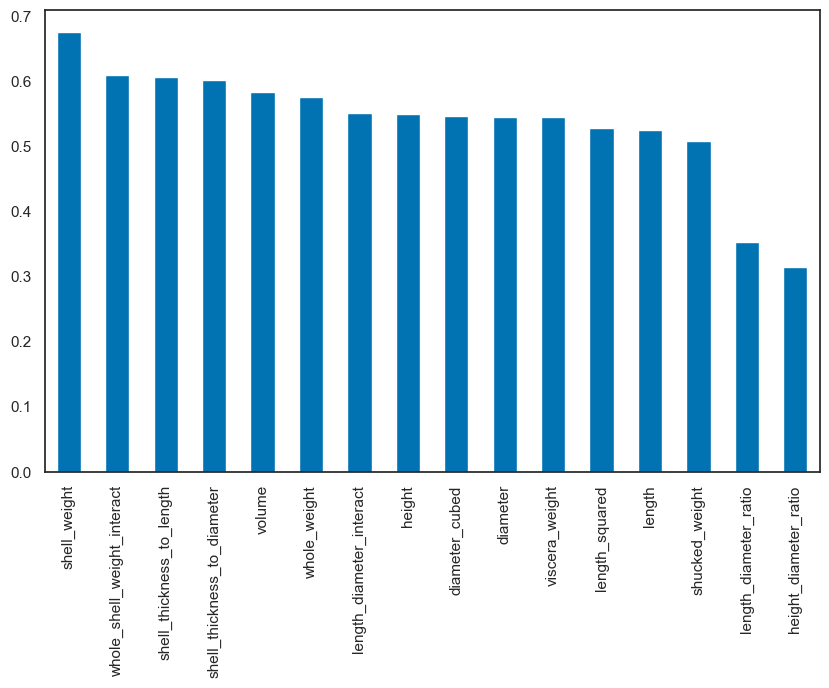

In [59]:
X_num = X.select_dtypes(exclude='object')   

# Calculate mutual information between each feature and the target
mi = mutual_info_regression(X_num, y, random_state=42)
mi = pd.Series(mi, index=X_num.columns)

# Sort the mutual information values in descending order
mi = mi.sort_values(ascending=False)

# Plot the mutual information values
plt.figure(figsize=(10, 6))
mi.plot.bar()

## Correlation

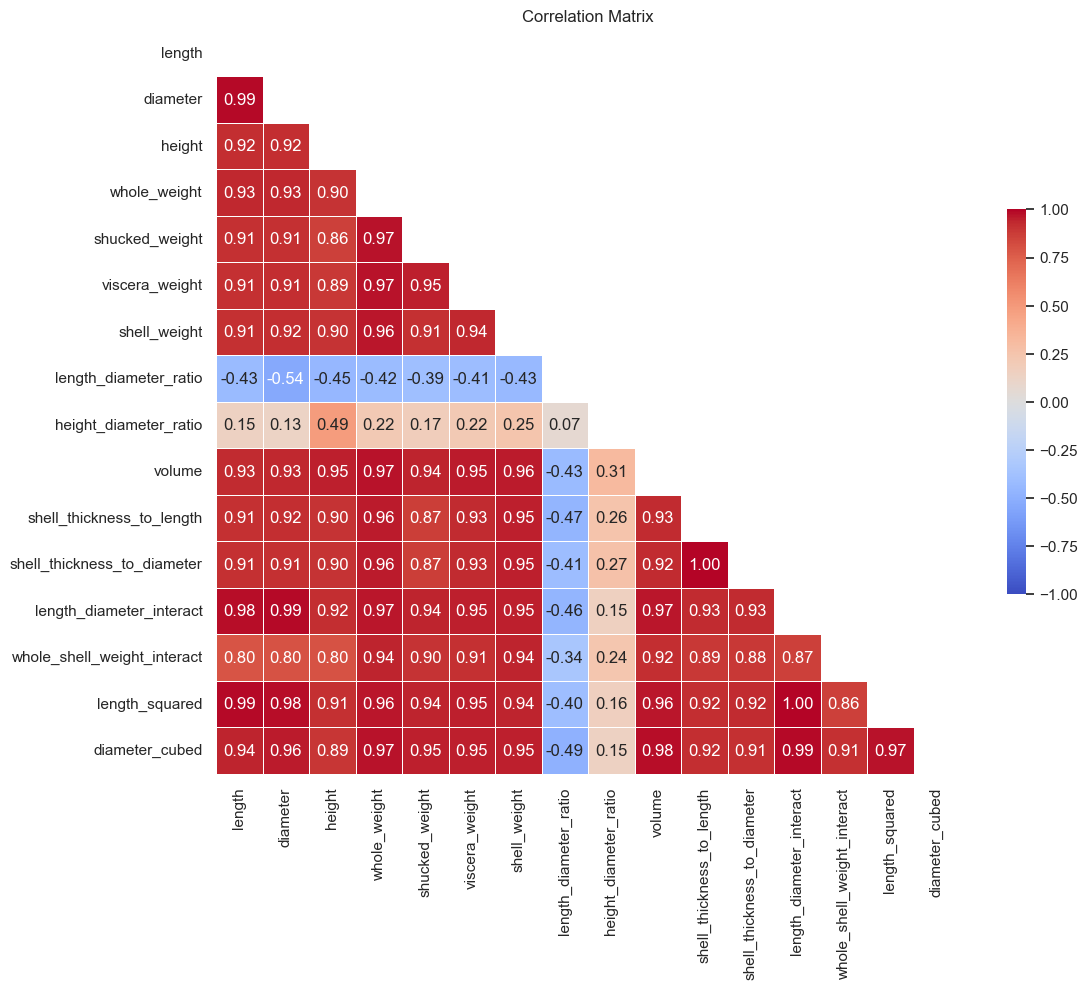

In [60]:
# correlation matrix
corr = X_num.select_dtypes(exclude='object').corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, mask=mask)
plt.title('Correlation Matrix')
plt.show()

# Preprocessing

## Pipeline

In [61]:
# Preprocessing pipeline for numerical features
numerical_pipeline = Pipeline([
    ('scaler', ColumnTransformer([
        ('minmax', MinMaxScaler(), minmax_list),
        ('standard', StandardScaler(), standard_list),
        ('robust', RobustScaler(), robust_list)
    ])
    )
])

# Preprocessing pipeline for categorical features
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine numerical and categorical pipelines
preprocessing = ColumnTransformer([
    ('numerical', numerical_pipeline, X_num.columns),
    ('categorical', categorical_pipeline, X.select_dtypes(include='object').columns)
])


preprocessing

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scaler',
                                                  ColumnTransformer(transformers=[('minmax',
                                                                                   MinMaxScaler(),
                                                                                   ['length',
                                                                                    'height',
                                                                                    'shucked_weight',
                                                                                    'viscera_weight',
                                                                                    'shell_weight',
                                                                                    'whole_shell_weight_interact',
                                                                                    'length_squared']),
                                                                                  ('standard',
                                                                                   StandardScaler(),
                                                                                   ['diameter',
                                                                                    'whole_weight',
                                                                                    'shell_thickness_to_length',
                                                                                    'shell_thickness_to_d...
       'viscera_weight', 'shell_weight', 'length_diameter_ratio',
       'height_diameter_ratio', 'volume', 'shell_thickness_to_length',
       'shell_thickness_to_diameter', 'length_diameter_interact',
       'whole_shell_weight_interact', 'length_squared', 'diameter_cubed'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['sex'], dtype='object'))])

## Tune Xgboost, LightGBM, Catboost Hyperparameters

### Xgboost

In [62]:
# def objective(trial):
    
#    # Define the hyperparameters to optimize
#    params = {
#       'n_estimators' : trial.suggest_int('n_estimators',10,5000),
#       'learning_rate' : trial.suggest_loguniform('learning_rate',0.01,1),
#       'min_child_weight' : trial.suggest_int('min_child_weight',1,10),
#       'max_depth' : trial.suggest_int('max_depth',1,50),
#       'max_delta_step' : trial.suggest_int('max_delta_step',0,20),
#       'subsample' : trial.suggest_uniform('subsample',0.1,1),
#       'colsample_bytree' : trial.suggest_uniform('colsample_bytree',0.1,1),
#       'colsample_bylevel' : trial.suggest_uniform('colsample_bylevel',0.1,1),
#       'reg_lambda' : trial.suggest_loguniform('reg_lambda',0.01,100),
#       'reg_alpha' : trial.suggest_loguniform('reg_alpha',0.01,100),
#       'gamma' : trial.suggest_loguniform('gamma',0.01,100),
#       'scale_pos_weight' : trial.suggest_loguniform('scale_pos_weight',0.01,500),
#    }
   
#    # Initialize XGBoost model with suggested hyperparameters
#    model = XGBRegressor(**params, random_state=SEED)    
   
#    # Create a pipeline with preprocessing and XGBoost model
#    xgb_pipe = Pipeline([
#       ('preprocessing', preprocessing),
#       ('xgboost', model)
#    ])
   
#    # Cross-validation with 5 folds
#    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
   
#    # Calculate the cross-validated negative RMSLE score
#    scores = -1 * cross_val_score(xgb_pipe,
#                                  X,
#                                  y,
#                                  cv=cv,
#                                  scoring='neg_root_mean_squared_log_error',
#                                  n_jobs=-1)
   
#    return scores.mean()

# %%time

# # # perform hyperparameter optimization with Optuna
# study = optuna.create_study(direction='minimize', study_name='xgboost_feature_selection')
# study.optimize(objective, n_trials=50)

# print('\n----------------------------------------\n')
# print(f'Best trial: {study.best_trial.params}')
# print(f'Best score: {study.best_value}')


#get study name best params
# study_name = study.study_name
# print(f'Study name: {study_name}')
# best_params = study.best_trial.params
# best_params

In [63]:
# %%time

# # # perform hyperparameter optimization with Optuna
# study = optuna.create_study(direction='minimize', study_name='xgboost_feature_selection')
# study.optimize(objective, n_trials=50)

# print('\n----------------------------------------\n')
# print(f'Best trial: {study.best_trial.params}')
# print(f'Best score: {study.best_value}')

In [64]:
#get study name best params
# study_name = study.study_name
# print(f'Study name: {study_name}')
# best_params = study.best_trial.params
# best_params

In [65]:
best_params_xgboost_feat_eng = { 'n_estimators': 2002,
                        'learning_rate': 0.023179807913033965,
                        'min_child_weight': 4,
                        'max_depth': 5,
                        'max_delta_step': 3,
                        'subsample': 0.9014435705025713,
                        'colsample_bytree': 0.5592550252819414,
                        'colsample_bylevel': 0.7913720329916152,
                        'reg_lambda': 20.807261214628618,
                        'reg_alpha': 0.2230920967505844,
                        'gamma': 0.047396187891504016,
                        'scale_pos_weight': 0.5161601206341146
                    }

In [66]:
def get_folds_rmsle(X, y, model, preprocessing):
    """
    Perform cross-validation with a given model and preprocessing pipeline.

    Parameters:
    X (DataFrame): Features.
    y (Series): Target.
    model: Model to evaluate.
    preprocessing: Preprocessing pipeline.
    n_splits (int): Number of splits for cross-validation.

    Returns:
    list: List of RMSLE scores for each fold.
    """

    # Create an empty list to store the scores
    fold_scores = []

    # Cross-validation with 5 folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    # Loop through each fold
    for train_index, test_index in cv.split(X, y):

        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create a pipeline with preprocessing and XGBoost model
        xgb_pipe = Pipeline([
            ('preprocessing', preprocessing),
            ('xgboost', model)
        ])

        # Fit the model
        xgb_pipe.fit(X_train, y_train)

        # Calculate the negative RMSLE score
        score = mean_squared_log_error(y_test, xgb_pipe.predict(X_test), squared=False)

        # Append the score to the list
        fold_scores.append(score)

    return fold_scores

In [67]:
# model with best params
model_xgb = XGBRegressor(**best_params_xgboost_feat_eng, random_state=SEED)

In [113]:
%%time

#Apply Recursive Feature Elimination to pipeline
min_features_to_select = 1  # Minimum number of features to consider

# Create a recursive feature eliminator
rfe = RFECV(
    estimator=model_xgb, 
    step=1, 
    cv=5, 
    scoring='neg_mean_squared_log_error',
    min_features_to_select=min_features_to_select,
    verbose=1,
    n_jobs=-1)

# Create a pipeline with preprocessing and RFE
rfe_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('rfe', rfe)
])

# Fit the RFE pipeline
rfe_pipe.fit(X, y)

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
CPU times: total: 5min 30s
Wall time: 5min 1s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   ColumnTransformer(transformers=[('minmax',
                                                                                                    MinMaxScaler(),
                                                                                                    ['length',
                                                                                                     'height',
                                                                                                     'shucked_weight',
                                                                                                     'viscera_weight',
                                                                                                     'shell_weight',
                                                                                                     'whole_shell_weight_interact',
                                                                                                     'length_squared']),
                                                                                                   ('standard',
                                                                                                    StandardScaler(),
                                                                                                    ['diameter',
                                                                                                     'whole_weight',
                                                                                                     'shell_thickness...
                                              learning_rate=0.023179807913033965,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=3, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=4, missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=2002, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...),
                       n_jobs=-1, scoring='neg_mean_squared_log_error',
                       verbose=1))])

In [145]:
len(rfe_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out())
len(rfe_pipe.named_steps['preprocessing'].transformers_[1][1].get_feature_names_out())

# get all names from the features
feature_names = list(X.columns) + list(rfe_pipe.named_steps['preprocessing'].transformers_[1][1].get_feature_names_out())

print(feature_names)

# Get the selected features
mask = [rfe_pipe.named_steps['rfe'].support_]

# select the features using the mask
selected_features = [feature for feature, selected in zip(feature_names, mask[0]) if selected]
print(selected_features)

# what feature were eliminated
eliminated_features = [feature for feature, selected in zip(feature_names, mask[0]) if not selected]

print(eliminated_features)

['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'length_diameter_ratio', 'height_diameter_ratio', 'volume', 'shell_thickness_to_length', 'shell_thickness_to_diameter', 'length_diameter_interact', 'whole_shell_weight_interact', 'length_squared', 'diameter_cubed', 'sex_F', 'sex_I', 'sex_M']
['sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'length_diameter_ratio', 'height_diameter_ratio', 'volume', 'shell_thickness_to_length', 'whole_shell_weight_interact', 'length_squared', 'sex_F']
['shell_thickness_to_diameter', 'length_diameter_interact', 'diameter_cubed', 'sex_I']


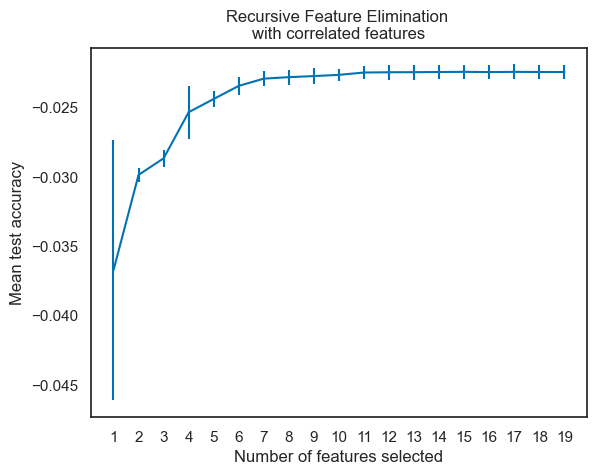

In [116]:
n_scores = len(rfe_pipe['rfe'].cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfe_pipe['rfe'].cv_results_["mean_test_score"],
    yerr=rfe_pipe['rfe'].cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.xticks(range(min_features_to_select, n_scores + min_features_to_select, 1))
plt.show()

In [ ]:
n_scores = len(rfe_pipe.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfe_pipe.cv_results_["mean_test_score"],
    yerr=rfe_pipe.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [155]:
rfe_optimized = Pipeline([
    ('rfe_opt', rfe_pipe),
    ('xgbost', model_xgb)
])

rfe_optimized.fit(X, y)

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.


Pipeline(steps=[('rfe_opt',
                 Pipeline(steps=[('preprocessing',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   Pipeline(steps=[('scaler',
                                                                                    ColumnTransformer(transformers=[('minmax',
                                                                                                                     MinMaxScaler(),
                                                                                                                     ['length',
                                                                                                                      'height',
                                                                                                                      'shucked_weight',
                                                                                                                      'viscera_weight',
                                                                                                                      'shell_weight',
                                                                                                                      'whole_shell_weight_interact',
                                                                                                                      'length_squared']),
                                                                                                                    ('standard',
                                                                                                                     StandardScaler(),
                                                                                                                     ['diameter',
                                                                                                                      'who...
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.023179807913033965, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=3, max_depth=5, max_leaves=None,
                              min_child_weight=4, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=2002, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [156]:
# save model
#joblib.dump(rfe_optimized, 'models/rfe_optimized_model.pkl')

['models/rfe_optimized_model.pkl']

## Predictions

In [158]:
# load the model
model = joblib.load('models/rfe_optimized_model.pkl')

# transform the test data 
test_transformed = preprocessing.transform(test)

# predict the test data
y_pred_xgb_feat_eng = model.predict(test)

y_pred_xgb_feat_eng[:10]

array([ 9.857938 ,  9.654436 , 10.096928 , 10.28496  ,  7.6976247,
        9.260939 , 11.25457  ,  6.228389 ,  7.9269724, 10.913225 ],
      dtype=float32)

In [159]:
# Create a DataFrame for the submission data
submission_data = pd.DataFrame(y_pred_xgb_feat_eng, index=test.index, columns=['rings'])

submission_data

,rings
id,
90615,9.857938
90616,9.654436
90617,10.096928
90618,10.284960
90619,7.697625
...,...
151021,6.467139
151022,9.179509
151023,13.366899


In [160]:
# Save the DataFrame to a CSV file

submission_data
submission_data.to_csv('outputs/submission_xgb_feat_eng.csv')

- kagge result with less features: `0.14843`